In [1]:
import Functions as F 
import pandas as pd 
import numpy as np 
import matplotlib as mat
%matplotlib qt 
# results = "runs/results05.csv"
# nr_agents = 6
# nr = 21
# Viz = F.VisualizeAngle(results, nr_agents)
# Viz.get_coor()
# Viz.plot_angle_in_plane(nr, True)

# Dij = F.Dijkstras(results, nr_agents, nr, Viz.R)
# Dij.run_dijkstra(6, 6)

ModuleNotFoundError: No module named 'Functions.computeAngle'

## Plot path on top of image

In [2]:
import SimpleITK as sitk 
import numpy as np 
import os 
import matplotlib.pyplot as plt 

Facial paths 

In [3]:
facial_paths = os.listdir("paths/paths_facial")
itkimage = sitk.ReadImage("Cmarl/src/data/images/Data_Scaled/ear1-P1051_2.nii.gz")

mask = sitk.GetArrayFromImage(sitk.ReadImage("paths/paths_facial/Landmark_ear1-P1051_2.nii.gz"))
im = sitk.GetArrayFromImage(itkimage)


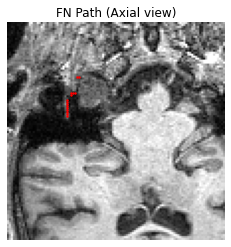

In [4]:
import statistics
x, y, z = np.where(mask == 1)
slice = statistics.mode(x)
slice = 69

plt.imshow(im[:, slice], cmap = "gray")
plt.scatter(z[y == slice], x[y == slice], color ="r", s = 2)
plt.title("FN Path (Axial view)")
plt.axis("off")
plt.show()

Chorda paths 

In [5]:
chorda_paths = os.listdir("paths/paths_chorda")
itkimage = sitk.ReadImage("Cmarl/src/data/images/Data_Scaled/ear1-P1051_2.nii.gz" )

mask2 = sitk.GetArrayFromImage(sitk.ReadImage("paths/paths_chorda/Landmark_ear1-P1051_2.nii.gz" ))
im = sitk.GetArrayFromImage(itkimage)


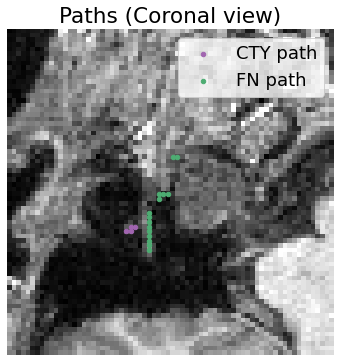

In [7]:
import statistics
x, y, z = np.where(mask2 == 1)
xq, yq, zq = np.where(mask == 1)
slice = statistics.mode(z)
slice = 69
import matplotlib as mat 
mat.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))

plt.imshow(im[0:70, slice, 0:70], cmap = "gray")
plt.scatter(z[y == slice], x[y == slice], color = [0.63215686, 0.39607843, 0.68980392], s = 20,label = "CTY path")
plt.scatter(zq[yq == slice], xq[yq == slice], color =[0.3 , 0.67333333, 0.4454902], s = 20,label = "FN path")
plt.title("Paths (Coronal view)")
plt.axis("off")
plt.legend()
plt.show()

In [14]:
print([x, y, z])

[array([42, 42, 42, 43, 43, 43], dtype=int64), array([69, 69, 70, 69, 69, 70], dtype=int64), array([26, 27, 27, 25, 26, 25], dtype=int64)]
